In [ ]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
FOLDER = '/content/gdrive/My Drive/pydev/workspace/study_ml/time-series/predict_stock_multivariate'
os.chdir(FOLDER)
print(os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/pydev/workspace/study_ml/time-series/predict_stock_multivariate


In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


### LSTM 학습용을 위한 데이터 생성. window개념 포함.


In [25]:
## LSTM 학습용을 위한 데이터 생성. window개념 포함.
def getSeriesData(data, window_size, elementdim=1):
	'''
	window_size 만큼의 데이터로 다음 데이터를 예측하기 위한 학습데이터 생성
	:param data: [1,2,3,4,5,6]
	:param window_size:
	:param elementdim:
	:return: x=[[1,2,3], [2,3,4], [3,4,5]]
	:return: y=[      4,       5,       6]
	'''
	n_pairs = len(data) - window_size # (x,y) pair 개수
	xlist = [data[i:i+window_size] for i in range(n_pairs)]

	ylist = [data[(i+1)+window_size] for i in range(n_pairs)]
	x = np.array(xlist, dtype=np.float32)
	y = np.array(ylist, dtype=np.float32)
	return x, y

In [8]:
x, y = getSeriesData([1,2,3,4,5,6,7,8,9,10], 3)
print(x.shape)
print(y)

(7, 3)
[ 4.  5.  6.  7.  8.  9. 10.]


In [26]:
x, y = getSeriesData([1,2,3,4,5,6,7,8,9,10], 3)
print(x)
print(y)

IndexError: list index out of range

In [2]:
# 학습용, 검증용, 테스트용 분할하기
def split_data(data, val_size=0.15, test_size=0.15):
  """
  splits data to training, validation and testing parts
  """
  ntest = int(round(len(data) * (1 - test_size)))
  nval = int(round(ntest * (1 - val_size)))
  
  train, validation, test = np.split(data, [nval, ntest])
  
  return train, validation, test

### 주가 데이터 csv파일 읽기

In [21]:
df = pd.read_csv('apple.csv', header=0)

In [22]:
#print(df)
df[:20] # jupyter에서는 print()없이 df라고만 쳐도 이쁘게 출력된다.

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.49,30.64,30.34,30.57,27.41,123432400.0
1,2010-01-05,30.66,30.80,30.46,30.63,27.45,150476200.0
2,2010-01-06,30.63,30.75,30.11,30.14,27.02,138040000.0
3,2010-01-07,30.25,30.29,29.86,30.08,26.97,119282800.0
4,2010-01-08,30.04,30.29,29.87,30.28,27.15,111902700.0
5,2010-01-11,30.40,30.43,29.78,30.02,26.91,115557400.0
6,2010-01-12,29.88,29.97,29.49,29.67,26.60,148614900.0
7,2010-01-13,29.70,30.13,29.16,30.09,26.98,151473000.0
8,2010-01-14,30.02,30.07,29.86,29.92,26.82,108223500.0
9,2010-01-15,30.13,30.23,29.41,29.42,26.37,148516900.0


### pandas를 이용한 데이터 처리: scaling

In [23]:
print('df.columns :\n', list(df.columns))
MAX_PRICE = df.High.max()
MAX_VOL = df.Volume.max()
print('MAX_PRICE : ', MAX_PRICE)
print('MAX_VOL : ', MAX_VOL)

df.Volume = df.Volume / MAX_VOL
df.Open = df.Open / MAX_PRICE
df.Close = df.Close / MAX_PRICE
df.High = df.High / MAX_PRICE
df.Low = df.Low / MAX_PRICE

df.columns :
 ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
MAX_PRICE :  177.2
MAX_VOL :  470249500.0


In [24]:
df = df[:40]

### train, validation, test 데이터 준비
### LSTM 용으로 series 데이터 준비

In [41]:
#df = df[df.Open != 0][['Open']]
df2 = df[df.Open != 0][['Open', 'Close', 'High', 'Low', 'Volume']]
df2['TARGET'] = [0,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,1,0,0,1]
xy = df2.as_matrix() # numpy 데이터
xy = df2.values # numpy 데이터
xy.shape

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


(40, 6)

In [42]:
xy

array([[0.17206546, 0.17251693, 0.17291196, 0.17121896, 0.26248279,
        0.        ],
       [0.17302483, 0.17285553, 0.1738149 , 0.17189616, 0.31999226,
        1.        ],
       [0.17285553, 0.17009029, 0.17353273, 0.16992099, 0.2935463 ,
        0.        ],
       [0.17071106, 0.16975169, 0.17093679, 0.16851016, 0.25365854,
        1.        ],
       [0.16952596, 0.17088036, 0.17093679, 0.16856659, 0.23796453,
        1.        ],
       [0.17155756, 0.16941309, 0.17172686, 0.16805869, 0.24573636,
        1.        ],
       [0.16862302, 0.16743792, 0.16913093, 0.16642212, 0.31603415,
        1.        ],
       [0.16760722, 0.16980813, 0.17003386, 0.16455982, 0.32211199,
        1.        ],
       [0.16941309, 0.16884876, 0.16969526, 0.16851016, 0.2301406 ,
        0.        ],
       [0.17003386, 0.16602709, 0.17059819, 0.16597065, 0.31582575,
        1.        ],
       [0.16794582, 0.17336343, 0.1734763 , 0.16709932, 0.38809589,
        0.        ],
       [0.17325056, 0

In [43]:
def getSeriesData(data, x_size, y_size):
    '''
    window_size 만큼의 데이터로 다음 데이터를 예측하기 위한 학습데이터 생성
    :param data: [1,2,3,4,5,6,7]
    :param x_size: X데이터의 window 사이즈
    :param y_size: Y데이터의 window 사이즈
    :return: x=[[1,2,3], [2,3,4], [3,4,5]]  if x_size=3
    :return: y=[  [4,5],   [5,6],   [6,7]]  if y_size=2
    '''
    n_pairs = len(data) - (x_size + y_size) + 1 # (x,y) pair 개수
    xlist = [data[i:i+x_size] for i in range(n_pairs)]
    ylist = [data[i+x_size:i+x_size+y_size] for i in range(n_pairs)]
    x = np.array(xlist, dtype=np.float32)
    y = np.array(ylist, dtype=np.float32)
    return x, y

In [44]:
train, validation, test = split_data(xy)
WINDOWSIZE = 3
y_size = 2
train_x, train_y = getSeriesData(train, WINDOWSIZE, y_size)
valid_x, valid_y = getSeriesData(validation, WINDOWSIZE, y_size)
test_x, test_y = getSeriesData(test, WINDOWSIZE, y_size)

print('TRAIN', train.shape)
print('VALID', validation.shape)
print('TEST', test.shape)
print('TRAIN X', train_x.shape)
print('TRAIN Y', train_y.shape)
print('TEST X', test_x.shape)
print('TEST Y', test_y.shape)

TRAIN (29, 6)
VALID (5, 6)
TEST (6, 6)
TRAIN X (25, 3, 6)
TRAIN Y (25, 2, 6)
TEST X (2, 3, 6)
TEST Y (2, 2, 6)


In [ ]:
print(train_x)
print('-----------------')
print(test_x)

In [46]:
train_x[0:4]

array([[[0.17206547, 0.17251693, 0.17291196, 0.17121896, 0.2624828 ,
         0.        ],
        [0.17302483, 0.17285553, 0.1738149 , 0.17189616, 0.31999227,
         1.        ],
        [0.17285553, 0.17009029, 0.17353272, 0.169921  , 0.2935463 ,
         0.        ]],

       [[0.17302483, 0.17285553, 0.1738149 , 0.17189616, 0.31999227,
         1.        ],
        [0.17285553, 0.17009029, 0.17353272, 0.169921  , 0.2935463 ,
         0.        ],
        [0.17071106, 0.16975169, 0.1709368 , 0.16851015, 0.25365853,
         1.        ]],

       [[0.17285553, 0.17009029, 0.17353272, 0.169921  , 0.2935463 ,
         0.        ],
        [0.17071106, 0.16975169, 0.1709368 , 0.16851015, 0.25365853,
         1.        ],
        [0.16952597, 0.17088036, 0.1709368 , 0.16856658, 0.23796453,
         1.        ]],

       [[0.17071106, 0.16975169, 0.1709368 , 0.16851015, 0.25365853,
         1.        ],
        [0.16952597, 0.17088036, 0.1709368 , 0.16856658, 0.23796453,
         1.    

In [103]:
a = [train_y[i][:,-1].tolist() for i in range(0, len(train_y))]

In [106]:
a = np.asarray(a)
a.shape

(25, 2)

### LSTM NN 구성 정의

In [ ]:
# 모델 구성하기
model = Sequential()
hidden_nodes = 120
model.add(LSTM(hidden_nodes, input_shape=(WINDOWSIZE, 5), 
               return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

for layer in model.layers:
  print('IN', layer.input_shape, 'OUT', layer.output_shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
IN (None, 30, 5) OUT (None, 120)
IN (None, 120) OUT (None, 120)
IN (None, 120) OUT (None, 1)


In [ ]:
# 모델 학습하기
# train_y[:, 2] --> [시가, 종가, 고가, 저가, 거래량] 중에 고가를 예측
hist = model.fit(train_x, train_y[:, 2], 
                 epochs=30, 
                 batch_size=64,
                 #validation_data=(valid_x, valid_y), 
                 shuffle=True,
                 verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1430/1430 [==============================] - 4s 3ms/step - loss: 0.0439
Epoch 2/30
1430/1430 [==============================] - 1s 723us/step - loss: 0.0067
Epoch 3/30
1430/1430 [==============================] - 1s 743us/step - loss: 0.0044
Epoch 4/30
1430/1430 [==============================] - 1s 745us/step - loss: 0.0039
Epoch 5/30
1430/1430 [==============================] - 1s 753us/step - loss: 0.0032
Epoch 6/30
1430/1430 [==============================] - 1s 747us/step - loss: 0.0029
Epoch 7/30
1430/1430 [==============================] - 1s 748us/step - loss: 0.0026
Epoch 8/30
1430/1430 [==============================] - 1s 752us/step - loss: 0.0026
Epoch 9/30
1430/1430 [==============================] - 1s 738us/step - loss: 0.0025
Epoch 10/30
1430/1430 [==============================] - 1s 736us/step - loss: 0.0022
Epoch 11/30
1430/1430 [==============================] - 1s 735us/step - loss: 0.0022
Epoch 12/30
1430/

In [ ]:
test_y2 = model.predict(test_x)
#print(test_y[:10, 2])
#print(test_y2[:10])
for y, y2 in zip(test_y[:50, 2], test_y2[:50]):
    y = y*MAX_PRICE
    y2 = y2*MAX_PRICE
    print('%.1f %.1f %.2f%%' % (y, y2, abs(y-y2)/y*100))

115.0 111.9 2.68%
115.9 112.6 2.86%
116.2 113.4 2.38%
116.7 114.3 2.10%
116.5 115.1 1.20%
117.4 115.8 1.33%
117.5 116.5 0.86%
117.4 117.1 0.28%
116.5 117.5 0.88%
116.5 117.7 1.04%
117.8 117.8 0.00%
118.0 117.9 0.07%
117.1 118.1 0.82%
117.2 118.1 0.75%
116.3 118.0 1.43%
116.5 117.8 1.10%
116.9 117.6 0.62%
118.2 117.5 0.58%
119.4 117.6 1.54%
119.4 118.0 1.18%
119.9 118.4 1.24%
119.3 119.0 0.27%
119.6 119.4 0.19%
120.2 119.7 0.43%
120.5 120.0 0.38%
120.1 120.3 0.22%
120.5 120.6 0.09%
120.8 120.8 0.03%
120.1 121.0 0.72%
122.1 121.0 0.87%
122.4 121.3 0.90%
122.4 121.7 0.52%
121.6 122.1 0.39%
121.4 122.3 0.77%
130.5 122.4 6.20%
129.4 123.6 4.46%
129.2 125.1 3.17%
130.5 126.5 3.05%
132.1 127.9 3.14%
132.2 129.3 2.18%
132.4 130.6 1.41%
132.9 131.6 0.99%
133.8 132.5 1.01%
135.1 133.2 1.37%
136.3 134.0 1.65%
135.9 134.8 0.78%
135.8 135.5 0.23%
136.7 136.1 0.51%
137.1 136.6 0.39%
137.5 137.1 0.29%


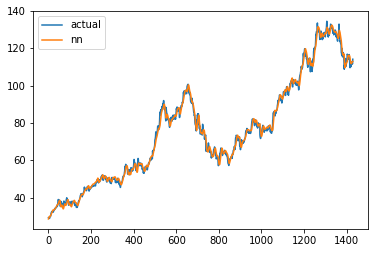

In [ ]:
train_y2 = model.predict(train_x)

fig, ax = plt.subplots()
ax.plot(train_y[:, 2] * MAX_PRICE, label='actual') # 고가
ax.plot(train_y2 * MAX_PRICE, label='nn')
plt.legend()
plt.show()

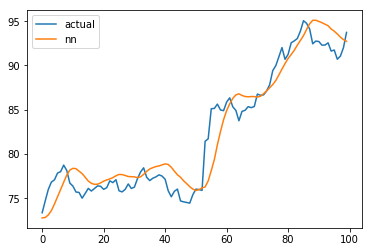

In [ ]:
train_y2 = model.predict(train_x)

fig, ax = plt.subplots()
ax.plot(train_y[1000:1100, 2] * MAX_PRICE, label='actual') # 고가
ax.plot(train_y2[1000:1100] * MAX_PRICE, label='nn')
plt.legend()
plt.show()

### scale된 상태의 수치로 그래프

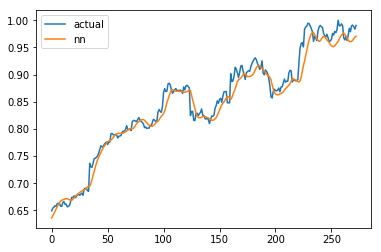

In [ ]:
fig, ax = plt.subplots()
ax.plot(test_y[:, 2], label='actual') # 고가
ax.plot(test_y2, label='nn')
plt.legend()
plt.show()

### 원래의 수치로 변환 후 그래프

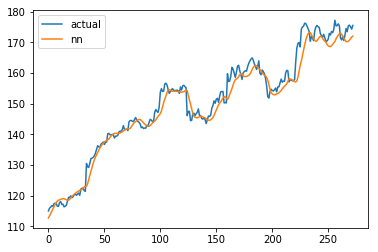

In [ ]:
fig, ax = plt.subplots()
ax.plot(test_y[:, 2] * MAX_PRICE, label='actual') # 고가
ax.plot(test_y2 * MAX_PRICE, label='nn')
plt.legend()
plt.show()